# Training con loss alternativa


L'intuzizione dietro il tentativo di usare questa loss era il provare a sfruttare la natura delle immagini, che sono composte in media da circa il solo 0.5% di pixel non spenti. Per provare a far converge più rapidamente e più stabilmente il modello, avere ricostruzioni migliori, e soprattutto evitare che il modello ricostruisca una soluzione triviale come un'immagine completamente vuota (che è comunque corretta nel 99.5% dei pixel), si è cercata una loss in grado di prendere in maggior considerazione gli errori sulla ricostruzione dei pixel attivi. è stato deciso di usare la Binary Cross Entropy, in particolare la versione che incorpora la Sigmoid al suo interno ```nn.BCEWithLogitsLoss()```: il valore di un pixel ricostruito viene trattato come la probabilità di trovare dell'energia depositata nel pixel, mentre le immagini in input sono trattate come la ground truth, essenzialmente agendo come una label e trattando il problema come una task di classificazione per determinare se un pixel è acceso o spento. Per via dei logaritmi nel calcolo della loss, essa sarà altissima se il modello predice confidentemente zero su un pixel accesso, come si voleva all'inizio. Usando la ```nn.BCEWithLogitsLoss()``` invece di ```nn.BCELoss()```, si ha inoltre l'accesso all'iperparametro ```pos_weight``` che consente di controllare quanto la loss sui pixel non-zero mal classificati ha peso rispetto al contrario. La conseguenza di questa scelta è che bisogna togliere la sigmoid all'ultimo layer e ogni volta che dobbiamo dobbiamo accedere alla ricostruzione di un immagine è necessario wrappare il modello in ```torch.sigmoid()```.

Vengono riportate solo i passaggi riguardanti il training e la scelta del threshold.

## Download dati

In [1]:
%%capture
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/G44/Test_data_low.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/G44/Test_data_high.npz

## Import librerie, controllo versione e disponibilità GPU

In [2]:
#versione di python
import sys
print(f'Versione Python: {sys.version}')

#multithreading per le funzioni che lo supportano
from multiprocessing import cpu_count
threads = cpu_count()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, classification_report

import umap

#torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary

print(f'Versione Torch: {torch.__version__}')
print(f'Versione Torchvision: {torchvision.__version__}')

if torch.cuda.is_available():
  print('GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
  device = 'cuda'
else:
  device = 'cpu'

print(f"Computation device: {device}")
print(f'Numero thread CPU: {threads}')

'''
Output sul mio environment:
Versione Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Versione Torch: 2.6.0+cu124
Versione Torchvision: 0.21.0+cu124
GPU disponibili:  1
GPU 0: NVIDIA L4
Computation device: cuda
Numero thread CPU: 12

''';

Versione Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Versione Torch: 2.6.0+cu124
Versione Torchvision: 0.21.0+cu124
GPU disponibili:  1
GPU 0: NVIDIA L4
Computation device: cuda
Numero thread CPU: 12


In [3]:
f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

normal_data = f_train['normal_data']
test_data_l = f_test_l['test_data']
test_data_h = f_test_h['test_data']

print(normal_data.shape)
print(test_data_l.shape)
print(test_data_h.shape)

(12000, 100, 100)
(3000, 100, 100)
(3000, 100, 100)


## Impostazione seed e generatore di numeri casuali

In [4]:
seed = 573
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

## Dati

In [5]:
#copio gli array per non toccare quelli originali
normal = np.copy(normal_data)
test_l = np.copy(test_data_l)
test_h = np.copy(test_data_h)

## Costruzione e addestramento dell'autoencoder

### Split training e test
È stato arbitrariamente scelto uno split 80/20 dei campioni normali.

In [6]:
train, validation = train_test_split(normal, test_size=0.2, random_state=seed, shuffle=True)

print(f'# training set: {len(train)}')
print(f'# validation set: {len(validation)}')

# training set: 9600
# validation set: 2400


### Creazione dataloader
Funzione per creare i vari dataloader necessari con batch size facilmente modificabile.

In [7]:
#autoencoder vuole shape N x ch x h x w, channels sono 1 in quanto l'intensità è praticamente grayscale
def createDataloaders(train, validation, test_h, test_l, batch_size):
    train_tsr = torch.tensor(train, dtype=torch.float32)
    train_tsr = train_tsr.unsqueeze(1)
    train_set = TensorDataset(train_tsr)
    train_ldr = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    val_tsr = torch.tensor(validation, dtype=torch.float32)
    val_tsr = val_tsr.unsqueeze(1)
    val_set = TensorDataset(val_tsr)
    val_ldr = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    val_ldr_1b = DataLoader(val_set, batch_size=1, shuffle=False) #1 batch per trovare il threshold

    test_h_tsr = torch.tensor(test_h, dtype=torch.float32)
    test_h_tsr = test_h_tsr.unsqueeze(1)
    test_h_set = TensorDataset(test_h_tsr)
    test_h_ldr = DataLoader(test_h_set, batch_size=1, shuffle=False)

    test_l_tsr = torch.tensor(test_l, dtype=torch.float32)
    test_l_tsr = test_l_tsr.unsqueeze(1)
    test_l_set = TensorDataset(test_l_tsr)
    test_l_ldr = DataLoader(test_l_set, batch_size=1, shuffle=False)

    return train_ldr, val_ldr, val_ldr_1b, test_h_ldr, test_l_ldr

### Instanziamento del modello

In [8]:
class CAE(nn.Module):
    def __init__(self, channels):
        super(CAE, self).__init__()
        self.channels = channels

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, self.channels, kernel_size=3, stride=1, padding=1), #1 x 100 x 100 -> ch x 100 x 100
            nn.BatchNorm2d(self.channels),
            nn.PReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.Conv2d(self.channels, 1, kernel_size=3, stride=1, padding=1), #ch x 100 x 100 -> 1 x 100 x 100
            #nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder_conv(x)
        decoded = self.decoder_conv(encoded)
        return decoded
model = CAE(4).to(device)
summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 100, 100]              40
       BatchNorm2d-2          [-1, 4, 100, 100]               8
             PReLU-3          [-1, 4, 100, 100]               1
            Conv2d-4          [-1, 1, 100, 100]              37
Total params: 86
Trainable params: 86
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.99
Params size (MB): 0.00
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


### Calcolo del peso degli errori sulle celle non vuote
Il fattore moltiplicativo è stato ottimizzato manualmente cercando di matchare la luminosità delle ricostruzioni sulle immagini del set di validazione con gli input.

In [9]:
#media su tutte le immagini dei pixel attivi
nonzero_pixels = np.count_nonzero(normal, axis=(1, 2))
total_pixels = 10000
f_nonzero = nonzero_pixels / 10000
avg_f_nonzero = np.mean(f_nonzero)
print(f"Pixel medi accesi in una immagine (normal set): {avg_f_nonzero:3f}")

pos_weight_value = 0.035/avg_f_nonzero
pos_weight = torch.tensor([pos_weight_value]).to(device)
print(f'pos_weight: {pos_weight_value:.3f}')

Pixel medi accesi in una immagine (normal set): 0.004716
pos_weight: 7.421


### Training loop

In [10]:
def trainLoop(model, train_loader, val_loader, epochs, learning_rate, weight_decay, pos_weight, print_img=False):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001)

    train_loss = []
    val_loss = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs = epochs
    patience = 10

    for epoch in range(epochs):
        #train
        model.train()
        running_loss = 0.0
        for data in train_ldr:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_ldr.dataset)
        train_loss.append(epoch_loss)

        #validation
        model.eval()
        val_loss_running = 0.0
        with torch.no_grad():
            for data in val_ldr:
                inputs = data[0].to(device)
                outputs = model(inputs)

                loss = criterion(outputs, inputs)
                val_loss_running += loss.item() * inputs.size(0)

        val_epoch_loss = val_loss_running / len(val_ldr.dataset)
        val_loss.append(val_epoch_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.7f}, Validation Loss: {val_epoch_loss:.7f}, Learning rate: {current_lr:.6f}')

        #early stopping
        if val_epoch_loss < 0.0015: #sotto questo threshold, diventa una identità
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), 'BCE_1conv_best.pth')
            print('Threshold raggiunto')
            break
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            epochs_no_improve = 0
            #salva il modello migliore
            torch.save(model.state_dict(), 'BCE_1conv_best.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping: {patience} epochs senza miglioramento.')
                break

        scheduler.step(val_epoch_loss)

        if (epoch + 1) % 5 == 0 and print_img==True:
            model.eval()
            with torch.no_grad():
                #prende la prima immagine dal batch, ricotruisce e la plotta
                images = next(iter(val_loader))[0]
                img = images[0].unsqueeze(0).to(device)
                reconstructed_img = torch.sigmoid(model(img))

                fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                axes[0].imshow(img.cpu().squeeze().numpy(), cmap='hot', vmin=0, vmax=1)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
                axes[1].imshow(reconstructed_img.cpu().squeeze().numpy(), cmap='hot', vmin=0, vmax=1)
                axes[1].set_title('Reconstructed Image')
                axes[1].axis('off')
                plt.show()

    return train_loss, val_loss

Epoch [1/100], Training Loss: 0.5894789, Validation Loss: 0.2360914, Learning rate: 0.000804
Epoch [2/100], Training Loss: 0.2016382, Validation Loss: 0.0935814, Learning rate: 0.000804
Epoch [3/100], Training Loss: 0.0383553, Validation Loss: 0.0178046, Learning rate: 0.000804
Epoch [4/100], Training Loss: 0.0139392, Validation Loss: 0.0104258, Learning rate: 0.000804
Epoch [5/100], Training Loss: 0.0075491, Validation Loss: 0.0069242, Learning rate: 0.000804


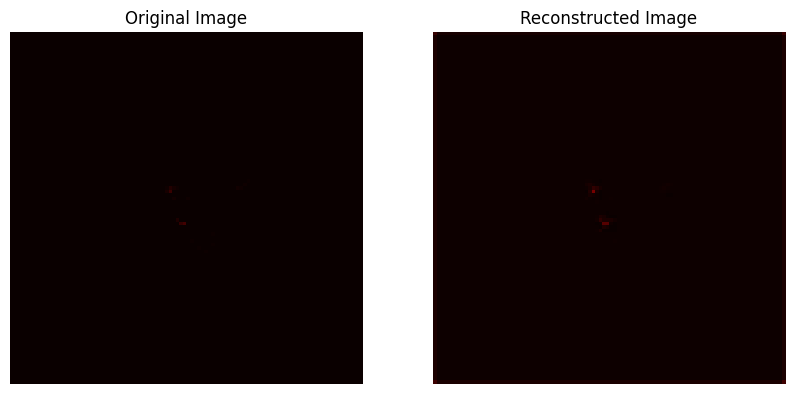

Epoch [6/100], Training Loss: 0.0050188, Validation Loss: 0.0077614, Learning rate: 0.000804
Epoch [7/100], Training Loss: 0.0037739, Validation Loss: 0.0029873, Learning rate: 0.000804
Epoch [8/100], Training Loss: 0.0030759, Validation Loss: 0.0034445, Learning rate: 0.000804
Epoch [9/100], Training Loss: 0.0026489, Validation Loss: 0.0025758, Learning rate: 0.000804
Epoch [10/100], Training Loss: 0.0023729, Validation Loss: 0.0023578, Learning rate: 0.000804


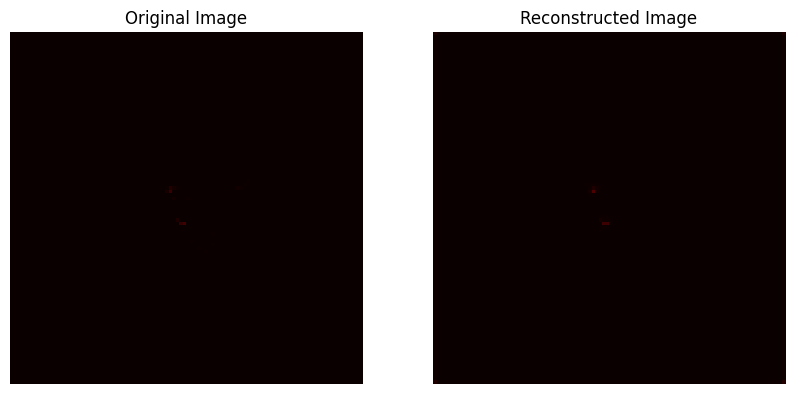

Epoch [11/100], Training Loss: 0.0021851, Validation Loss: 0.0020284, Learning rate: 0.000804
Epoch [12/100], Training Loss: 0.0020536, Validation Loss: 0.0019136, Learning rate: 0.000804
Epoch [13/100], Training Loss: 0.0019595, Validation Loss: 0.0018451, Learning rate: 0.000804
Epoch [14/100], Training Loss: 0.0018901, Validation Loss: 0.0018345, Learning rate: 0.000804
Epoch [15/100], Training Loss: 0.0018399, Validation Loss: 0.0018573, Learning rate: 0.000804


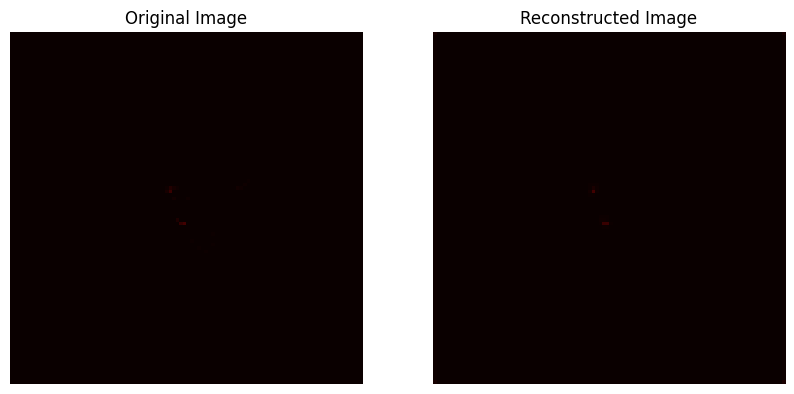

Epoch [16/100], Training Loss: 0.0018007, Validation Loss: 0.0017351, Learning rate: 0.000804
Epoch [17/100], Training Loss: 0.0017723, Validation Loss: 0.0017148, Learning rate: 0.000804
Epoch [18/100], Training Loss: 0.0017514, Validation Loss: 0.0017921, Learning rate: 0.000804
Epoch [19/100], Training Loss: 0.0017353, Validation Loss: 0.0017739, Learning rate: 0.000804
Epoch [20/100], Training Loss: 0.0017227, Validation Loss: 0.0017029, Learning rate: 0.000804


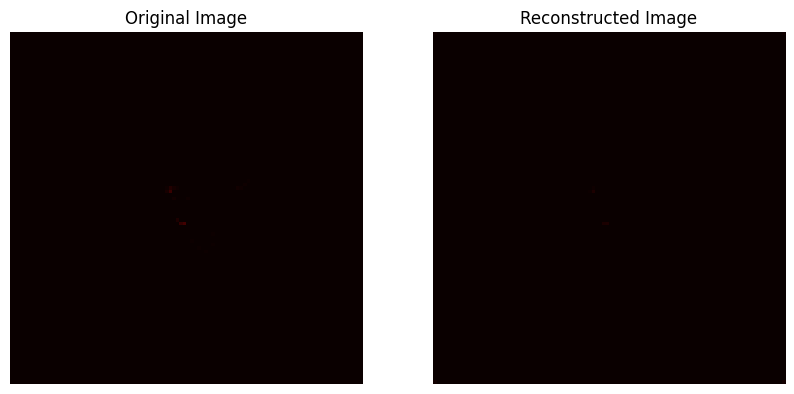

Epoch [21/100], Training Loss: 0.0017144, Validation Loss: 0.0019311, Learning rate: 0.000804
Epoch [22/100], Training Loss: 0.0017069, Validation Loss: 0.0017217, Learning rate: 0.000804
Epoch [23/100], Training Loss: 0.0017020, Validation Loss: 0.0017693, Learning rate: 0.000804
Epoch [24/100], Training Loss: 0.0016973, Validation Loss: 0.0017033, Learning rate: 0.000804
Epoch [25/100], Training Loss: 0.0016950, Validation Loss: 0.0016920, Learning rate: 0.000804


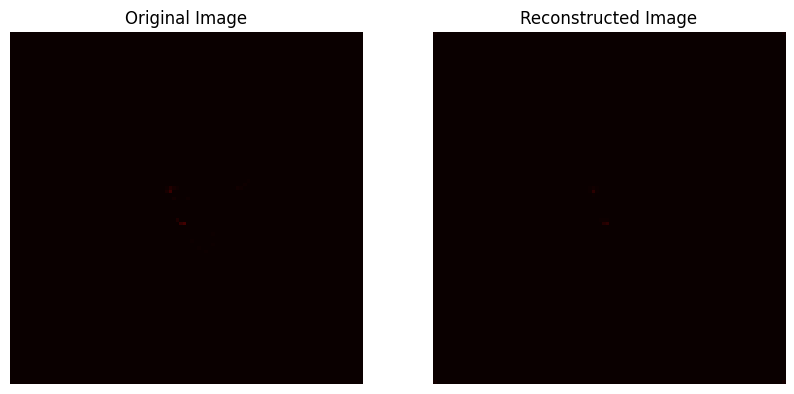

Epoch [26/100], Training Loss: 0.0016915, Validation Loss: 0.0016986, Learning rate: 0.000804
Epoch [27/100], Training Loss: 0.0016912, Validation Loss: 0.0017228, Learning rate: 0.000804
Epoch [28/100], Training Loss: 0.0016885, Validation Loss: 0.0016866, Learning rate: 0.000804
Epoch [29/100], Training Loss: 0.0016870, Validation Loss: 0.0018453, Learning rate: 0.000804
Epoch [30/100], Training Loss: 0.0016856, Validation Loss: 0.0016866, Learning rate: 0.000804


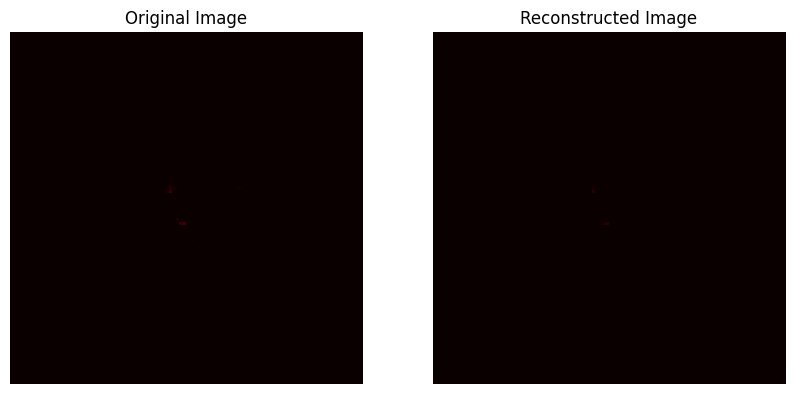

Epoch [31/100], Training Loss: 0.0016852, Validation Loss: 0.0017114, Learning rate: 0.000804
Epoch [32/100], Training Loss: 0.0016840, Validation Loss: 0.0017441, Learning rate: 0.000804
Epoch [33/100], Training Loss: 0.0016833, Validation Loss: 0.0016847, Learning rate: 0.000804
Epoch [34/100], Training Loss: 0.0016818, Validation Loss: 0.0016864, Learning rate: 0.000804
Epoch [35/100], Training Loss: 0.0016810, Validation Loss: 0.0017029, Learning rate: 0.000804


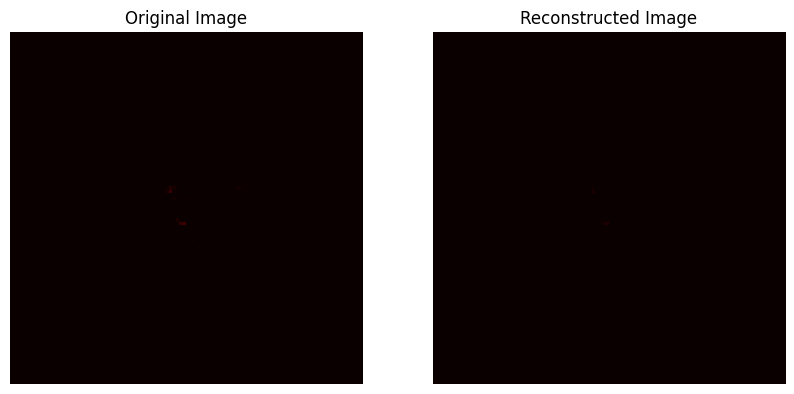

Epoch [36/100], Training Loss: 0.0016793, Validation Loss: 0.0016911, Learning rate: 0.000804
Epoch [37/100], Training Loss: 0.0016780, Validation Loss: 0.0016795, Learning rate: 0.000804
Epoch [38/100], Training Loss: 0.0016777, Validation Loss: 0.0017206, Learning rate: 0.000804
Epoch [39/100], Training Loss: 0.0016749, Validation Loss: 0.0016842, Learning rate: 0.000804
Epoch [40/100], Training Loss: 0.0016749, Validation Loss: 0.0018426, Learning rate: 0.000804


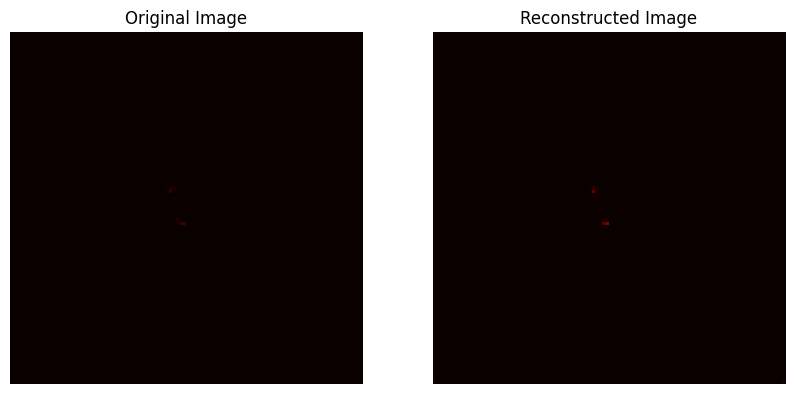

Epoch [41/100], Training Loss: 0.0016729, Validation Loss: 0.0016882, Learning rate: 0.000804
Epoch [42/100], Training Loss: 0.0016715, Validation Loss: 0.0017078, Learning rate: 0.000804
Epoch [43/100], Training Loss: 0.0016704, Validation Loss: 0.0016758, Learning rate: 0.000804
Epoch [44/100], Training Loss: 0.0016680, Validation Loss: 0.0017751, Learning rate: 0.000804
Epoch [45/100], Training Loss: 0.0016671, Validation Loss: 0.0016659, Learning rate: 0.000804


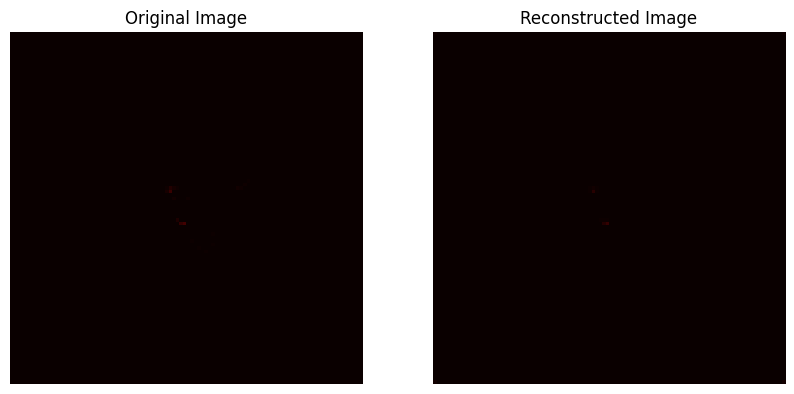

Epoch [46/100], Training Loss: 0.0016647, Validation Loss: 0.0018049, Learning rate: 0.000804
Epoch [47/100], Training Loss: 0.0016647, Validation Loss: 0.0017006, Learning rate: 0.000804
Epoch [48/100], Training Loss: 0.0016619, Validation Loss: 0.0016686, Learning rate: 0.000804
Epoch [49/100], Training Loss: 0.0016588, Validation Loss: 0.0017629, Learning rate: 0.000804
Epoch [50/100], Training Loss: 0.0016565, Validation Loss: 0.0016877, Learning rate: 0.000804


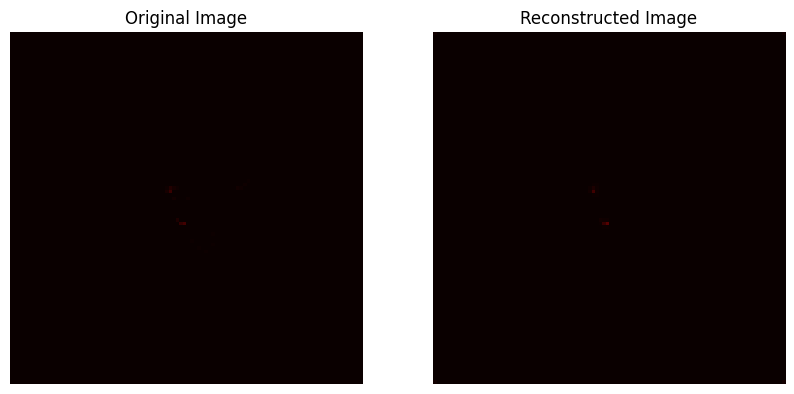

Epoch [51/100], Training Loss: 0.0016532, Validation Loss: 0.0016557, Learning rate: 0.000804
Epoch [52/100], Training Loss: 0.0016497, Validation Loss: 0.0016716, Learning rate: 0.000804
Epoch [53/100], Training Loss: 0.0016474, Validation Loss: 0.0017272, Learning rate: 0.000804
Epoch [54/100], Training Loss: 0.0016436, Validation Loss: 0.0016403, Learning rate: 0.000804
Epoch [55/100], Training Loss: 0.0016396, Validation Loss: 0.0016361, Learning rate: 0.000804


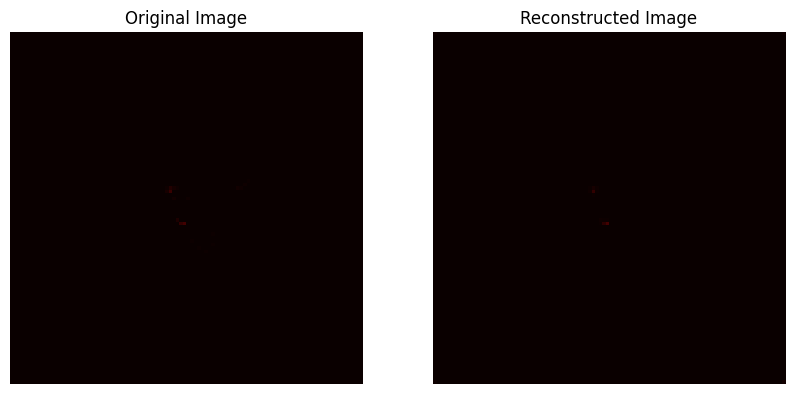

Epoch [56/100], Training Loss: 0.0016374, Validation Loss: 0.0016301, Learning rate: 0.000804
Epoch [57/100], Training Loss: 0.0016312, Validation Loss: 0.0016666, Learning rate: 0.000804
Epoch [58/100], Training Loss: 0.0016279, Validation Loss: 0.0016235, Learning rate: 0.000804
Epoch [59/100], Training Loss: 0.0016218, Validation Loss: 0.0016370, Learning rate: 0.000804
Epoch [60/100], Training Loss: 0.0016159, Validation Loss: 0.0016350, Learning rate: 0.000804


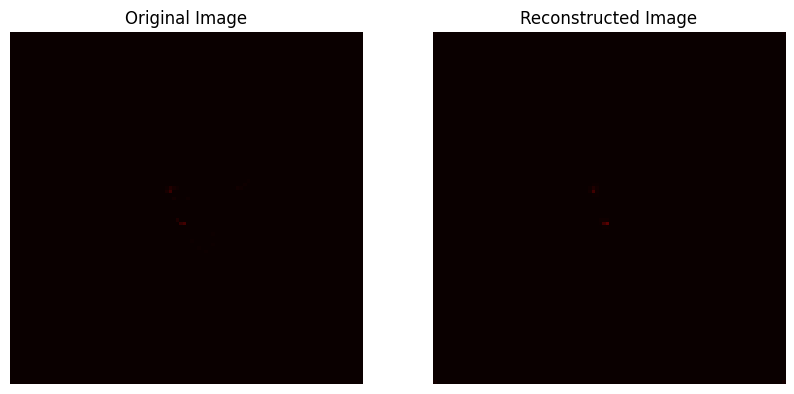

Epoch [61/100], Training Loss: 0.0016098, Validation Loss: 0.0016176, Learning rate: 0.000804
Epoch [62/100], Training Loss: 0.0016037, Validation Loss: 0.0016372, Learning rate: 0.000804
Epoch [63/100], Training Loss: 0.0015959, Validation Loss: 0.0037777, Learning rate: 0.000804
Epoch [64/100], Training Loss: 0.0015882, Validation Loss: 0.0016639, Learning rate: 0.000804
Epoch [65/100], Training Loss: 0.0015800, Validation Loss: 0.0015843, Learning rate: 0.000804


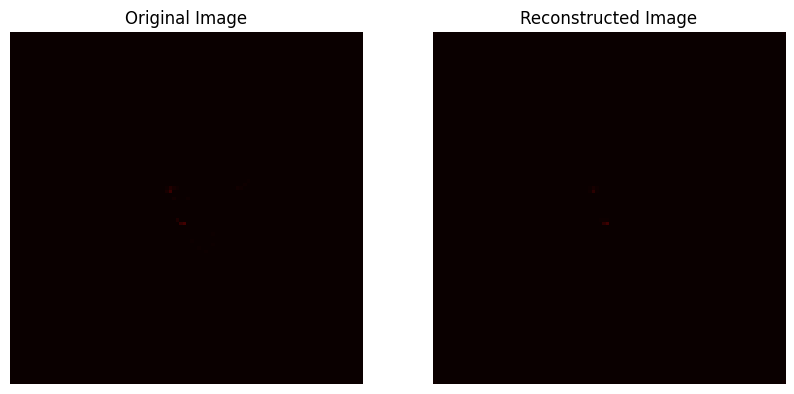

Epoch [66/100], Training Loss: 0.0015665, Validation Loss: 0.0015643, Learning rate: 0.000804
Epoch [67/100], Training Loss: 0.0015539, Validation Loss: 0.0016307, Learning rate: 0.000804
Epoch [68/100], Training Loss: 0.0015387, Validation Loss: 0.0015358, Learning rate: 0.000804
Epoch [69/100], Training Loss: 0.0015211, Validation Loss: 0.0015428, Learning rate: 0.000804
Epoch [70/100], Training Loss: 0.0014992, Validation Loss: 0.0014974, Learning rate: 0.000804
Threshold raggiunto


In [11]:
print_img=True
model = CAE(4).to(device)
train_ldr, val_ldr, val_ldr_1b, test_h_ldr, test_l_ldr = createDataloaders(train, validation, test_h, test_l, 64)
train_loss, val_loss = trainLoop(model, train_ldr, val_ldr, epochs=100, learning_rate=0.0008042910826443865, weight_decay=1.3494732750268131e-06, pos_weight=pos_weight, print_img=print_img)

### Grafico Epoch-Loss

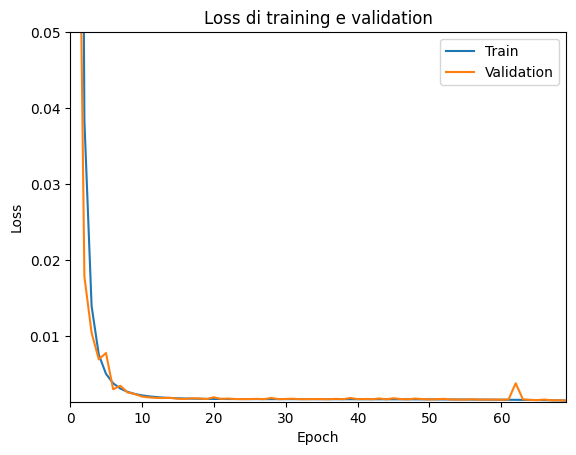

In [12]:
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss di training e validation')
plt.xlim(0, len(train_loss)-1)
#per il minimo del grafico
min_loss = min(min(train_loss), min(val_loss))
plt.ylim(min_loss*0.9, 0.05)
plt.show()

La loss di validazione è piuttosto noisy (probabilmente il learning rate iniziale è troppo alto) ma grazie allo scheduler riesce comunque a convergere bene.

## Stima percentuali di anomalie

In [14]:
#testing
model.eval()
reconstruction_criterion = nn.MSELoss()

def calculateReconstructionErrors(dataloader, model, reconstruction_criterion, device):
    errors = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data[0].to(device)
            reconstructions = torch.sigmoid(model(inputs))

            error_per_element = reconstruction_criterion(reconstructions, inputs)
            error_score = torch.sum(error_per_element).item()
            errors.append(error_score)

    return np.array(errors)

#calcolo errori
recon_err_l = calculateReconstructionErrors(test_l_ldr, model, reconstruction_criterion, device)
recon_err_h = calculateReconstructionErrors(test_h_ldr, model, reconstruction_criterion, device)
recon_err_val = calculateReconstructionErrors(val_ldr_1b, model, reconstruction_criterion, device)

#normalizzazione
scaler = MaxAbsScaler()
scaler.fit(recon_err_val.reshape(-1, 1))

norm_err_val = scaler.transform(recon_err_val.reshape(-1, 1))
norm_err_l   = scaler.transform(recon_err_l.reshape(-1, 1))
norm_err_h   = scaler.transform(recon_err_h.reshape(-1, 1))

In [15]:
#90esimo percentile errori di validation
anomaly_threshold = np.percentile(norm_err_val, 90)
print(f"Anomaly threshold per FPR <= 10%: {anomaly_threshold:.4f}")

Anomaly threshold per FPR <= 10%: 0.0664


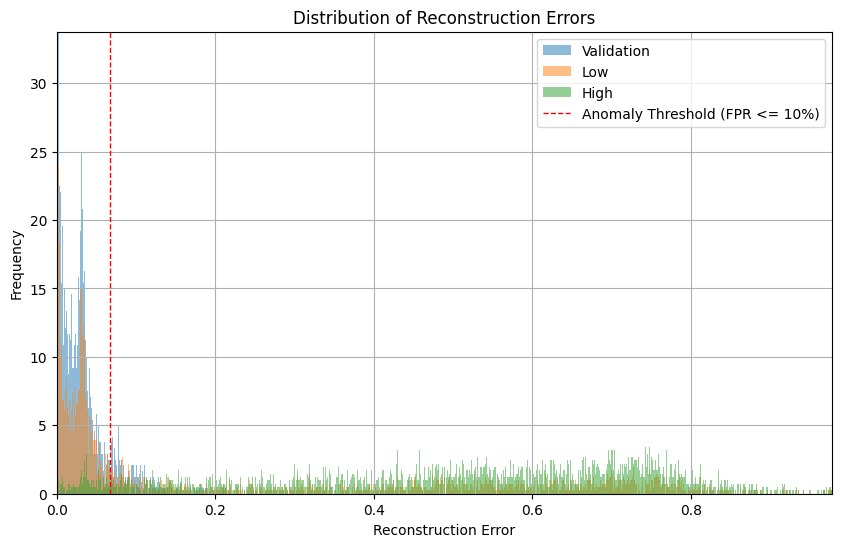

In [16]:
plt.figure(figsize=(10, 6))
#per visualizzare bene l'istogramma, uso la 99% del max dell'anomaly score e il 99.5% della freq più alta del validation
n,_,_ = plt.hist(norm_err_val, bins=1000, alpha=0.5, label='Validation',density=True)
plt.hist(norm_err_l, bins=1000, alpha=0.5, label='Low',density=True)
plt.hist(norm_err_h, bins=1000, alpha=0.5, label='High',density=True)
plt.axvline(anomaly_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Anomaly Threshold (FPR <= 10%)')

plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')

plt.xlim(0, np.percentile(norm_err_h, 99))
plt.ylim(0, np.percentile(n, 99.8))
plt.legend()
plt.grid(True)
plt.show()

Le ricostruzioni di questo modello per i dati normali del set low e di validazioni sono evidentemente migliori di quelle del modello allenato con la MSE: sembra quasi che il modello abbia imparato l'identità ma solo per i dati normali, mentre le anomalie risultano in una grande area illuminata al centro. Differente è la situazione invece per il set high, in cui sono presenti grandi quantità di falsi positivi.

Plot di 20 immagini casuali con errore > 0.0664:
Low:


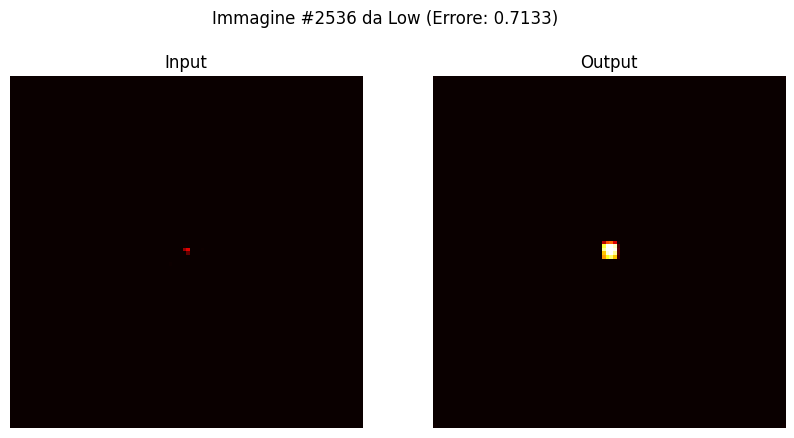

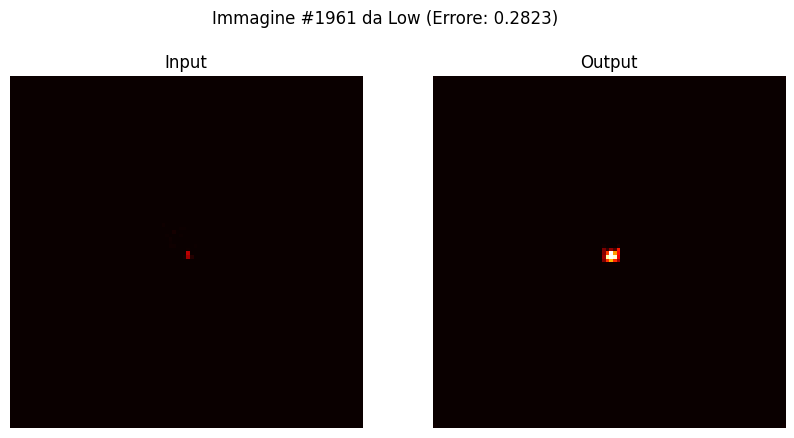

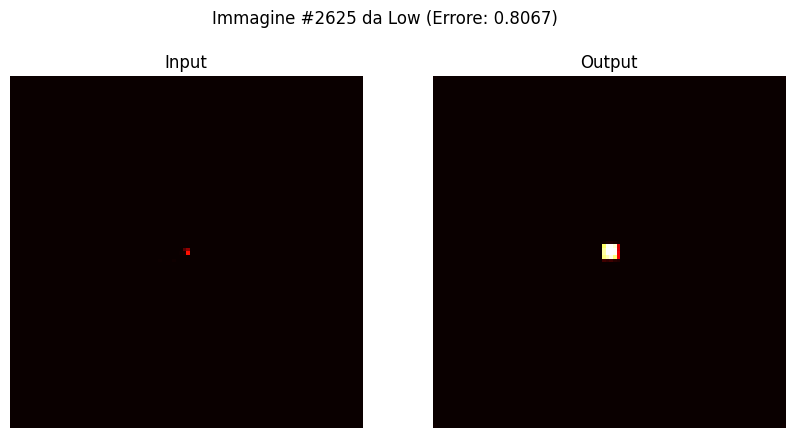

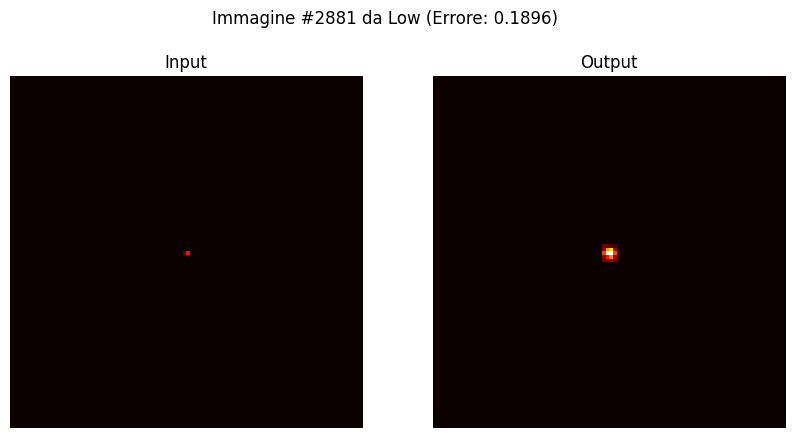

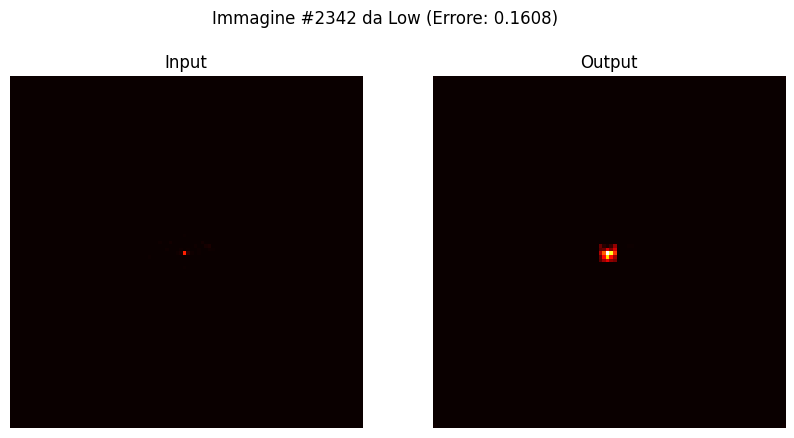

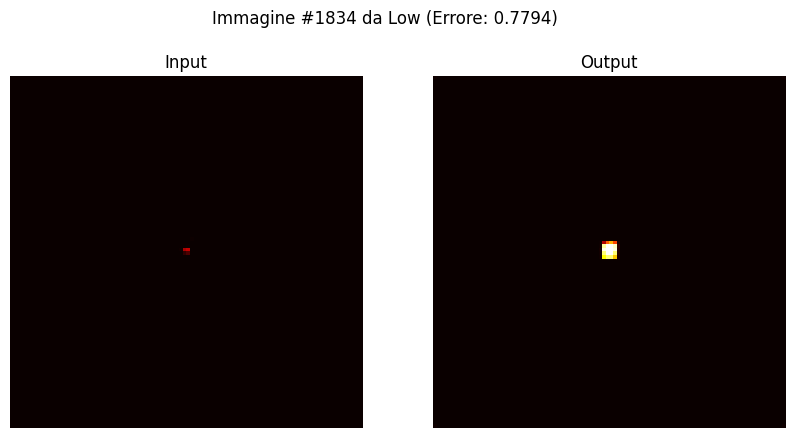

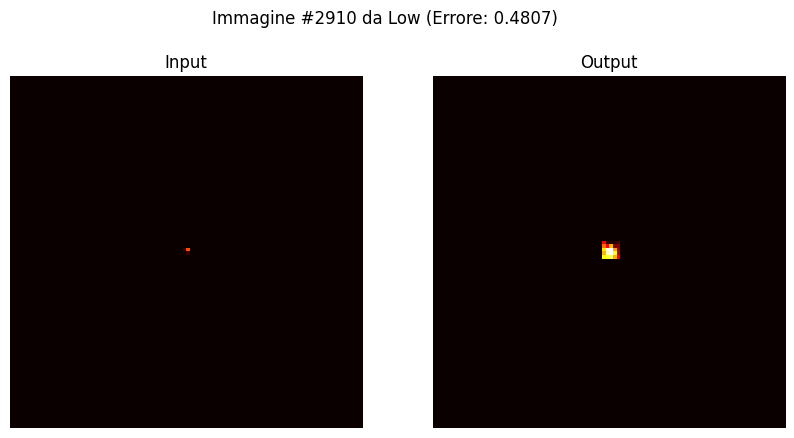

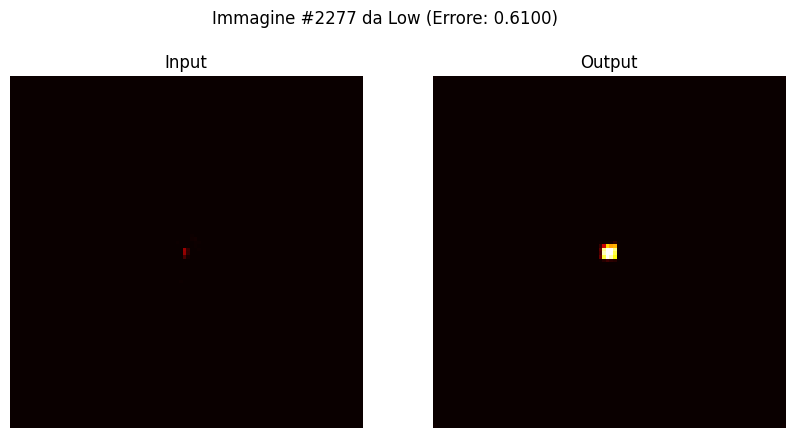

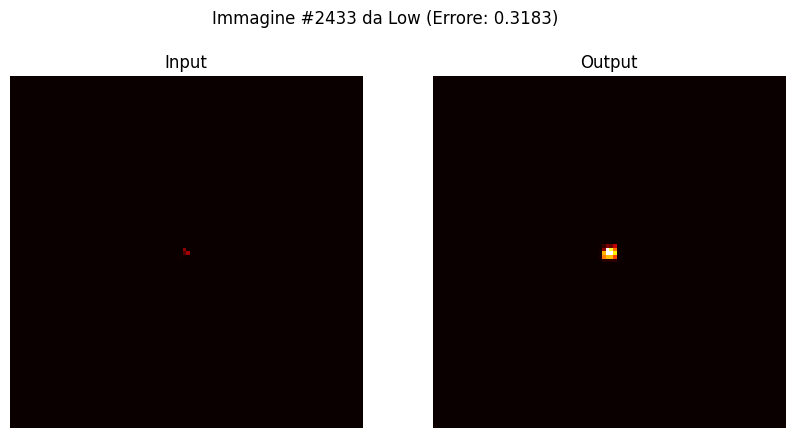

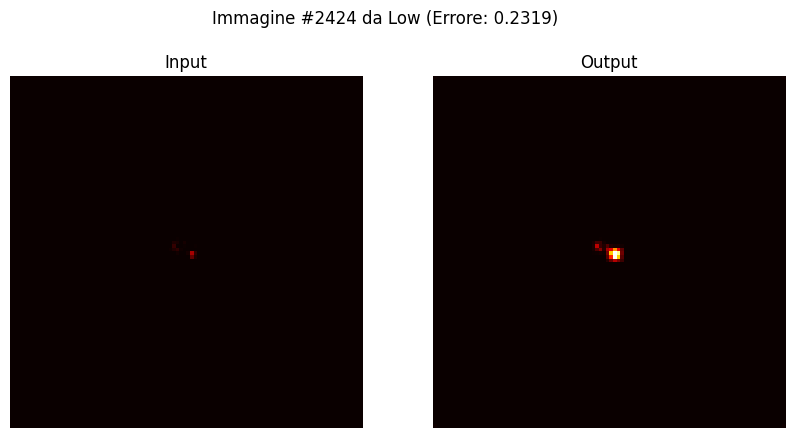

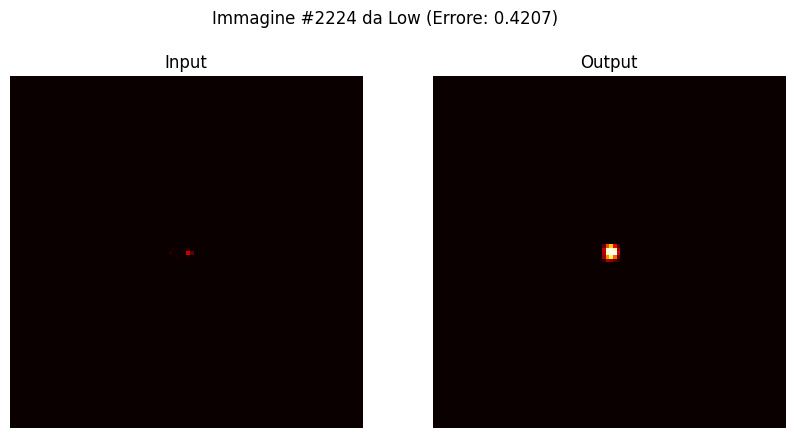

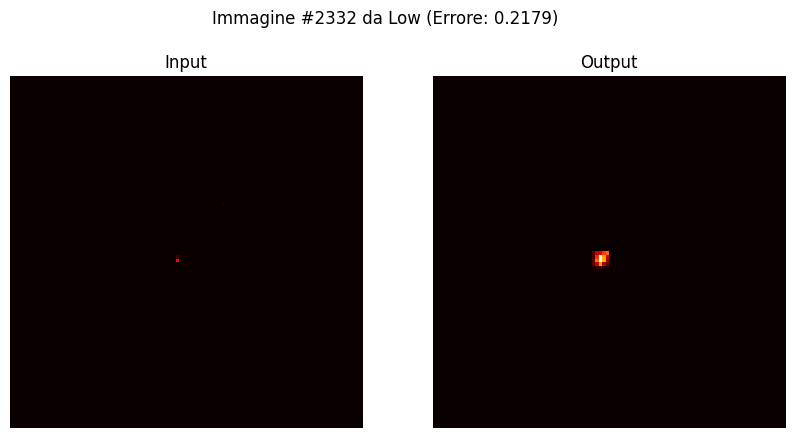

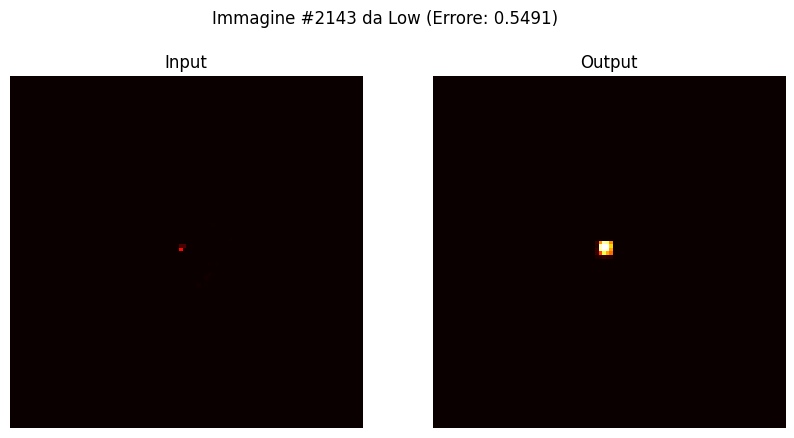

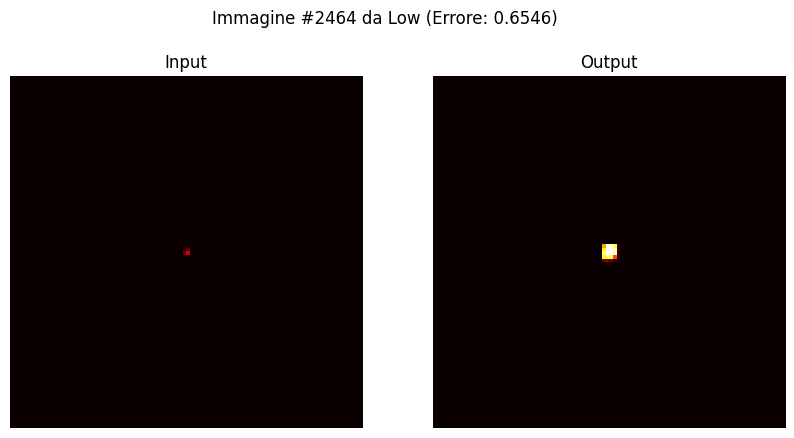

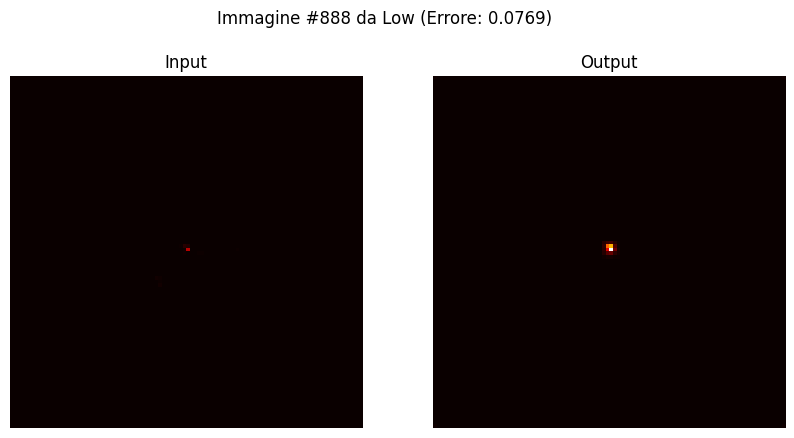

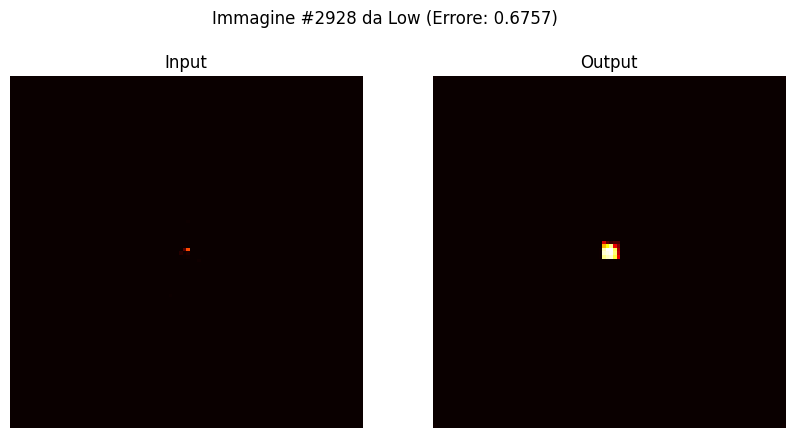

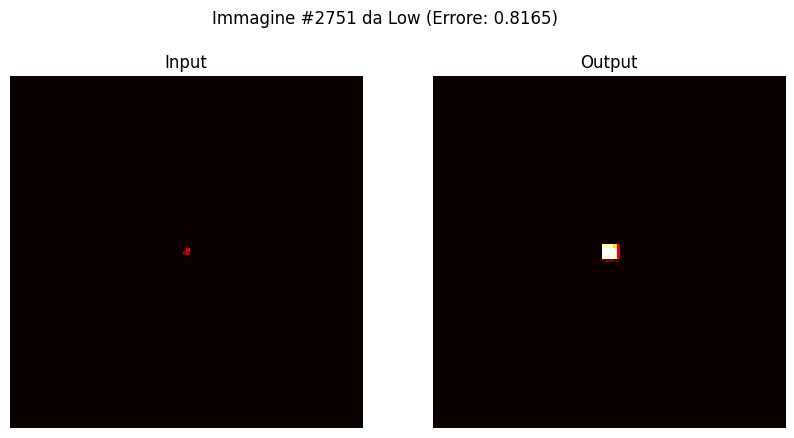

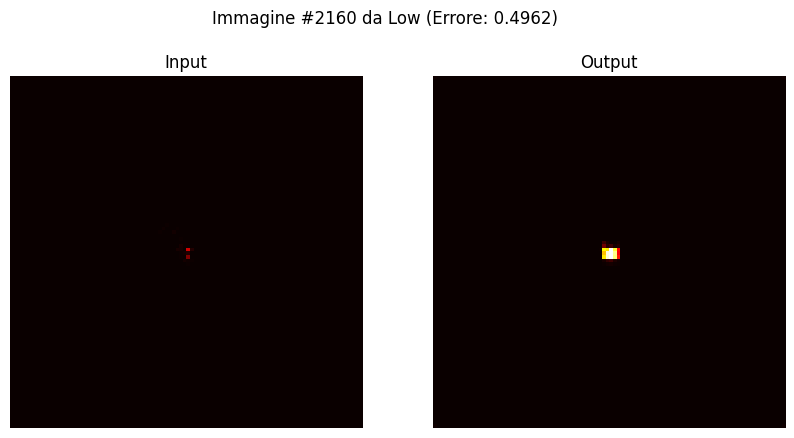

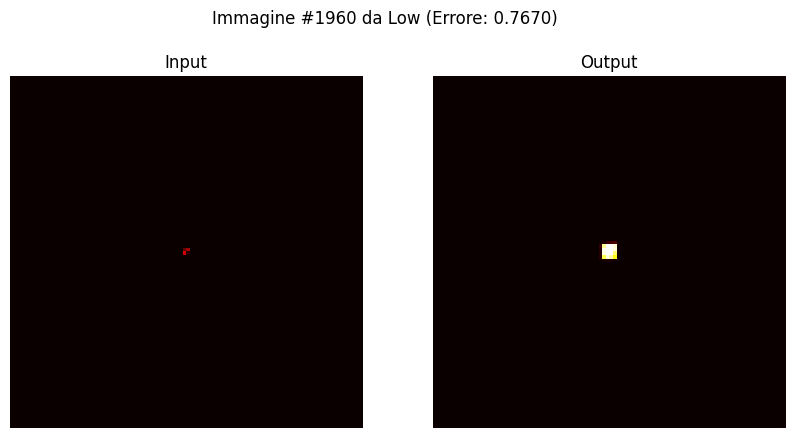

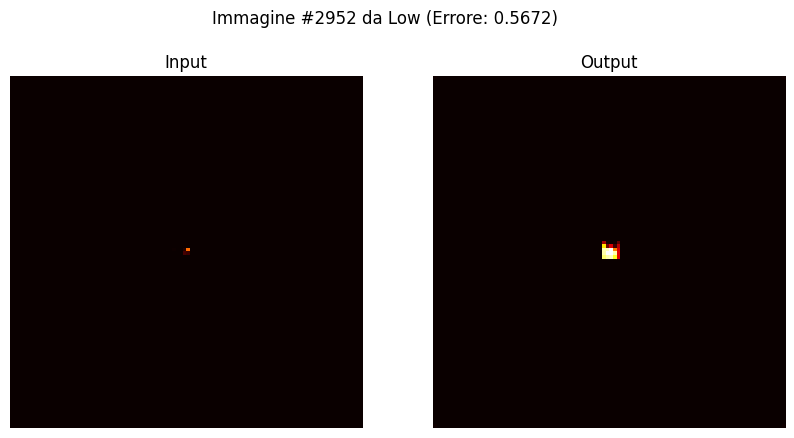

High:


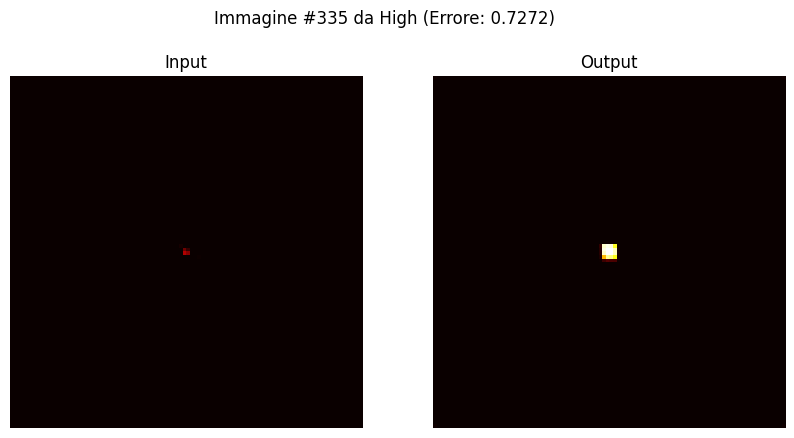

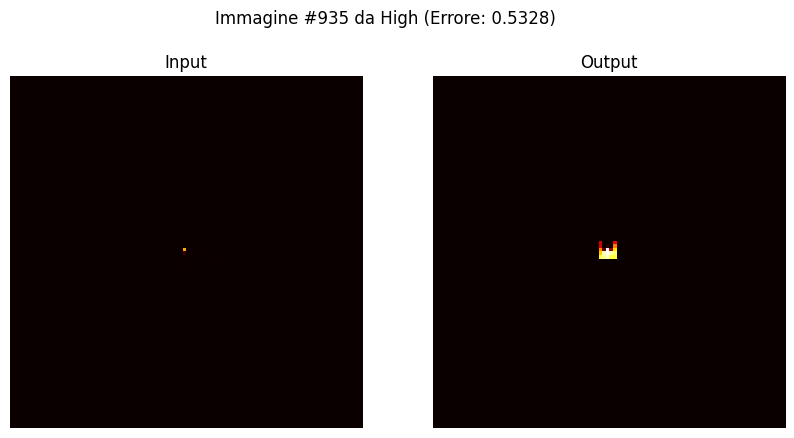

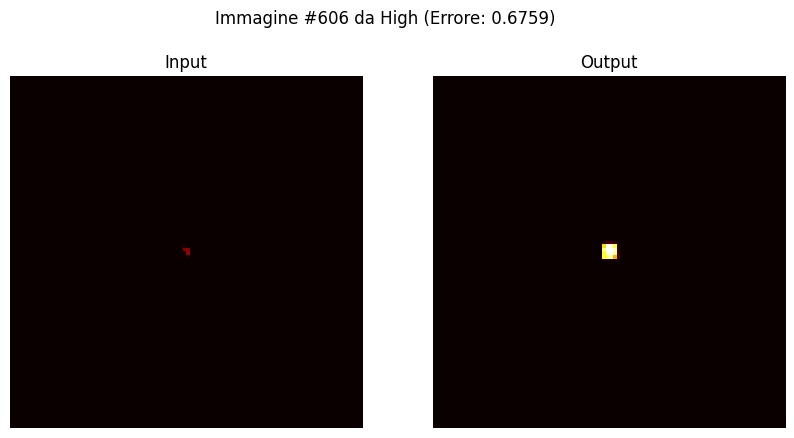

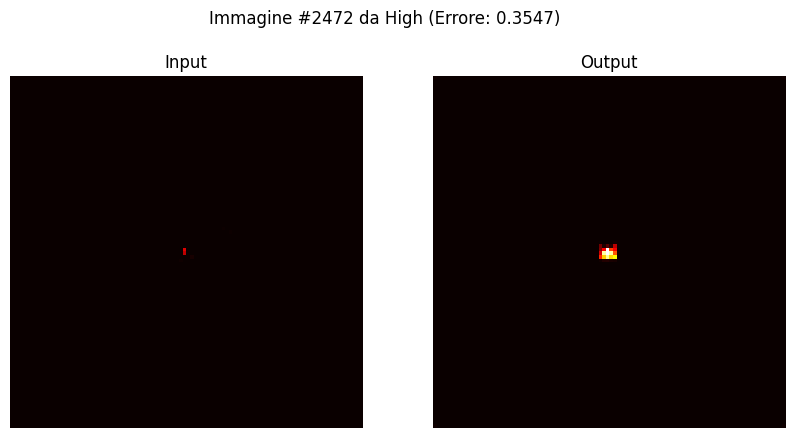

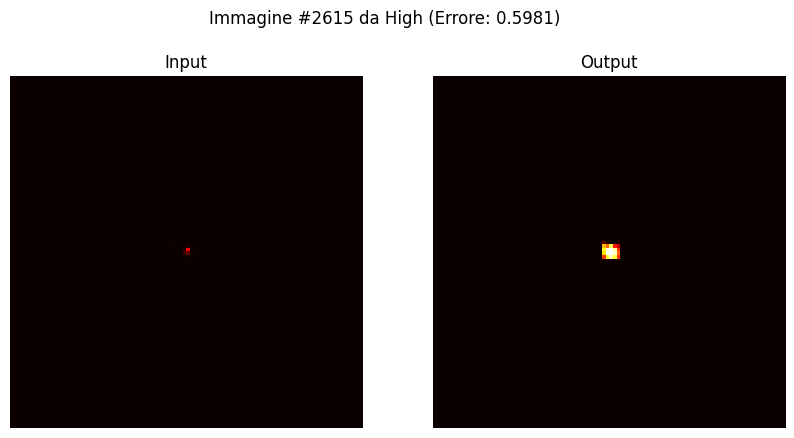

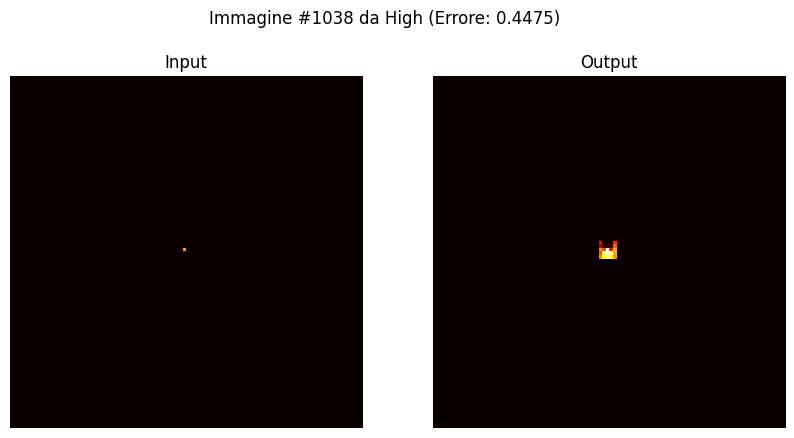

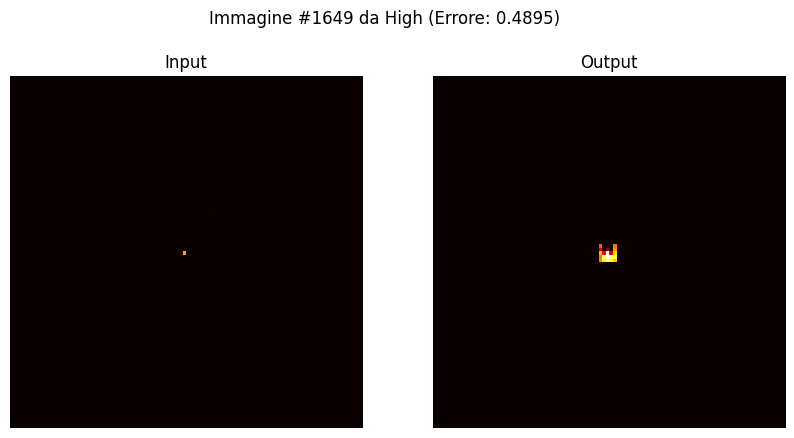

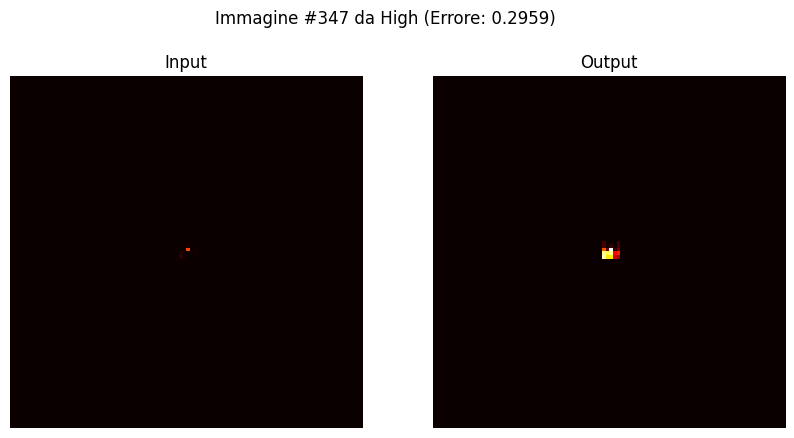

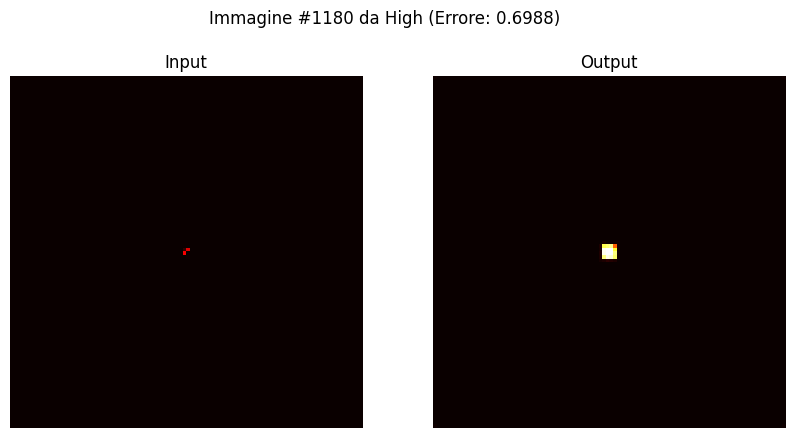

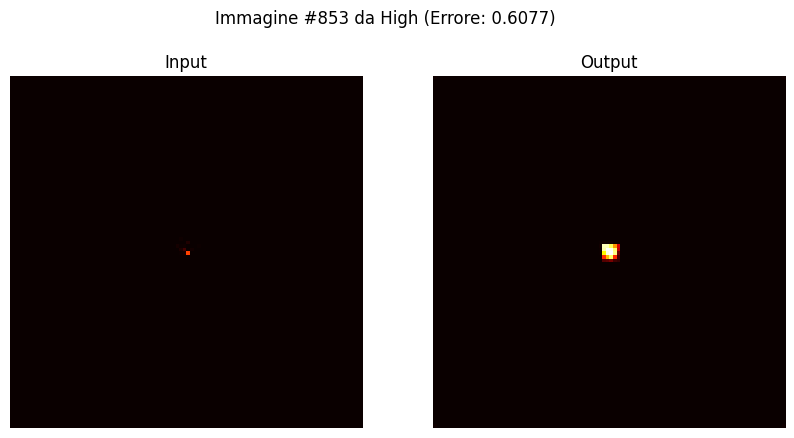

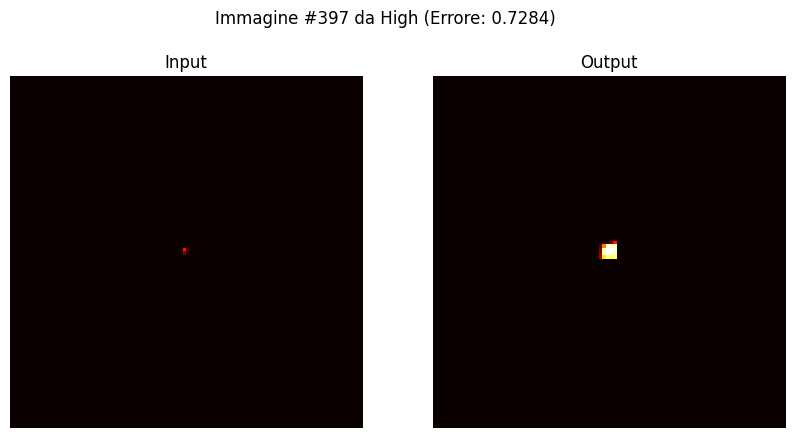

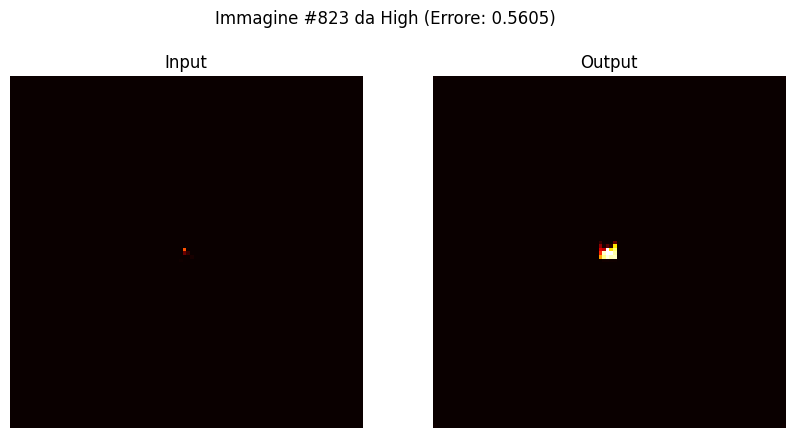

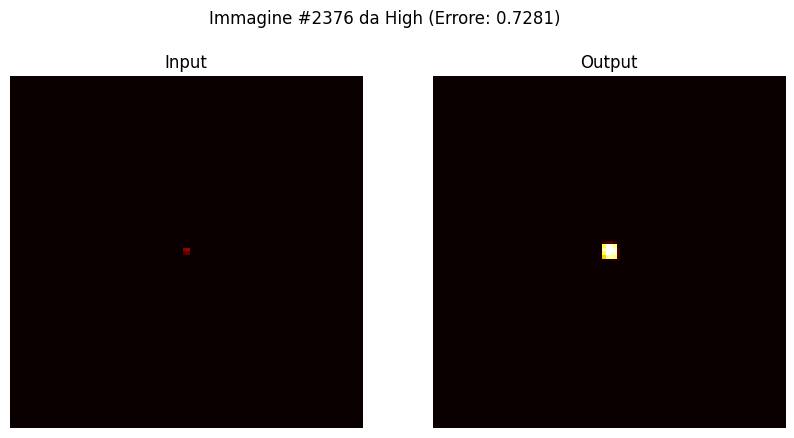

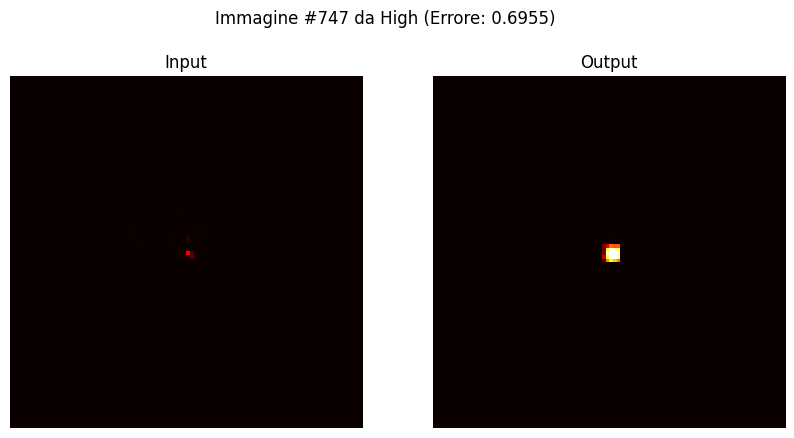

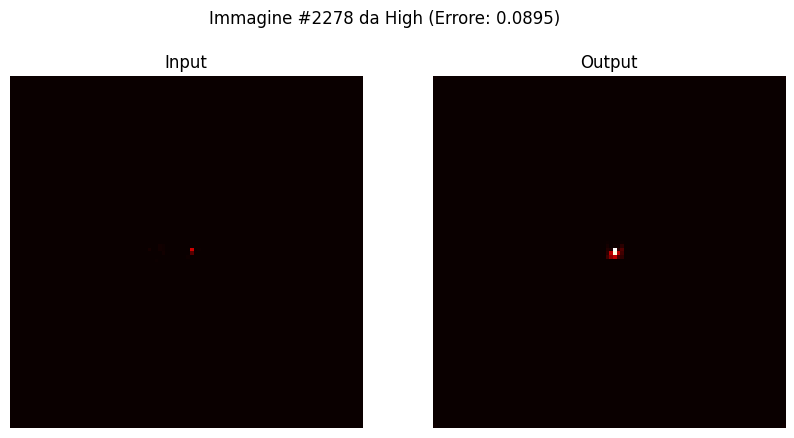

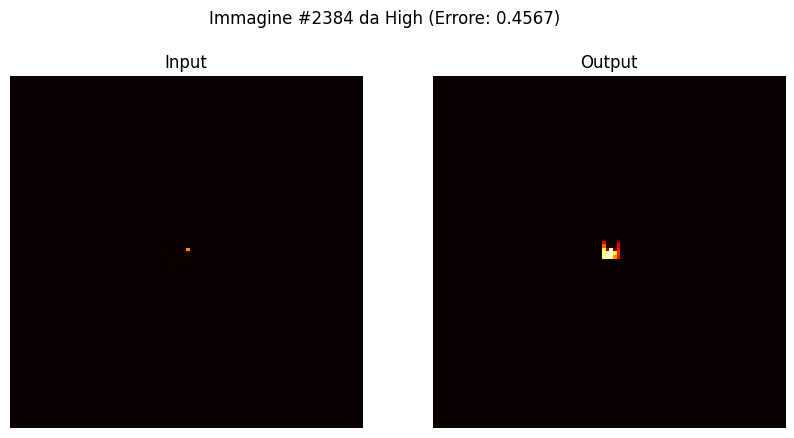

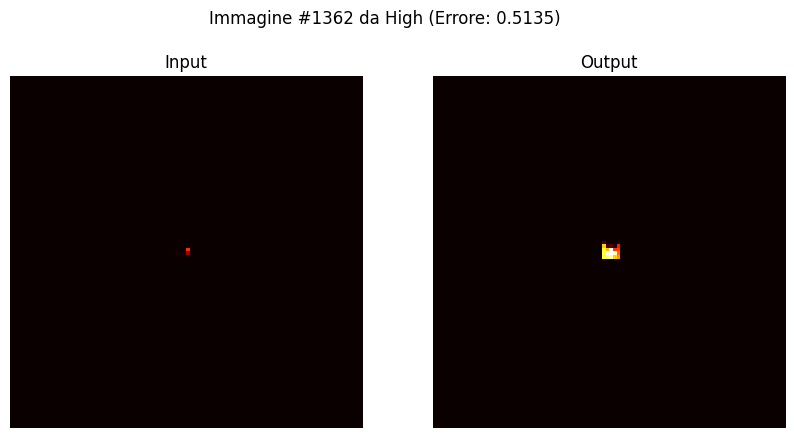

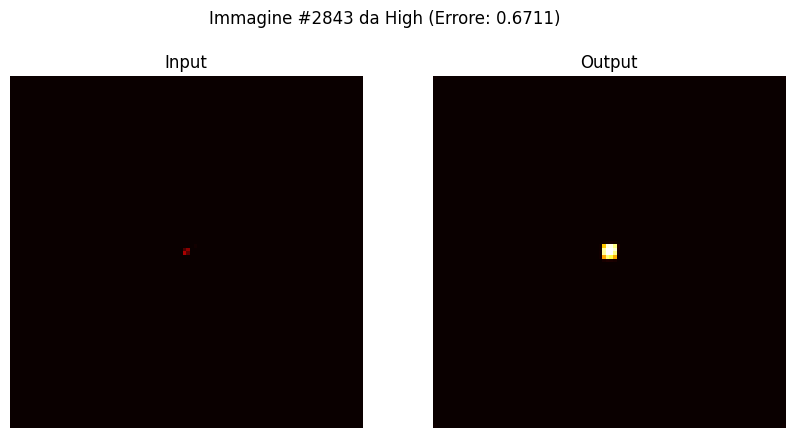

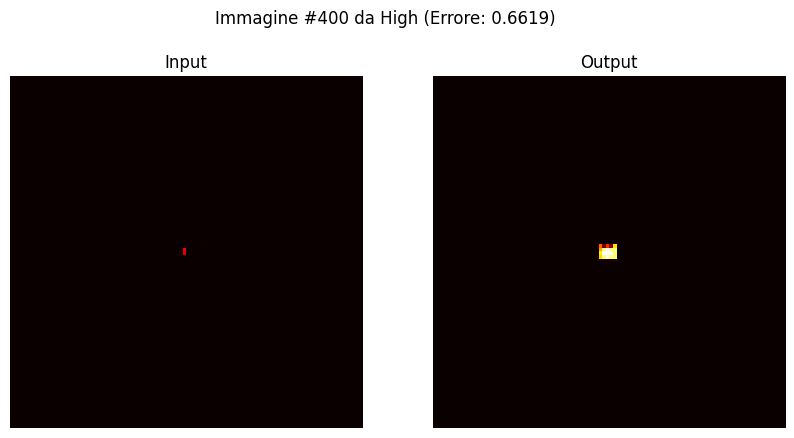

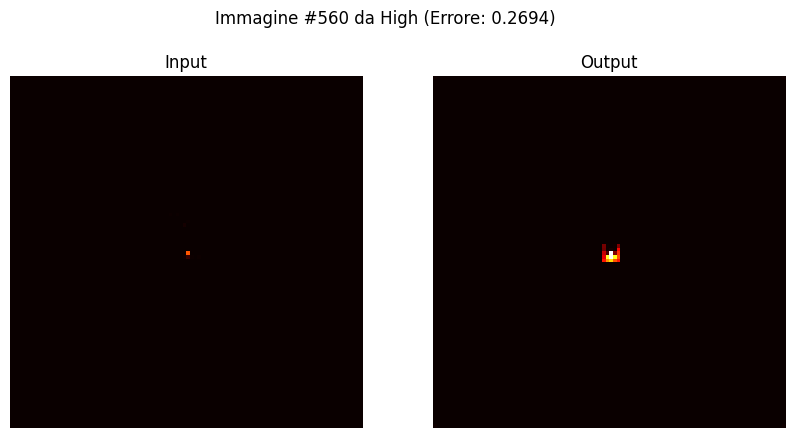

In [17]:
higher = 1 #se plottare immagini sopra o sotto il threshold

#indici di dove si trovano o meno le anomalie
normal_idxs_l = np.where(norm_err_l < anomaly_threshold)[0]
normal_idxs_h = np.where(norm_err_h < anomaly_threshold)[0]
anomal_idxs_l = np.where(norm_err_l > anomaly_threshold)[0]
anomal_idxs_h = np.where(norm_err_h > anomaly_threshold)[0]

num_images = 20

if higher==True:
    idxs_plot_l = anomal_idxs_l
    idxs_plot_h = anomal_idxs_h
else:
    idxs_plot_l = normal_idxs_l
    idxs_plot_h = normal_idxs_h

#immagini random tra il tipo scelto
rng_plot_idxs_l = rng.choice(idxs_plot_l, num_images, replace=False)
rng_plot_idxs_h = rng.choice(idxs_plot_h, num_images, replace=False)


model.eval()
with torch.no_grad():
    if higher==True:
      print(f"Plot di {num_images} immagini casuali con errore > {anomaly_threshold:.4f}:")
    else:
      print(f"Plot di {num_images} immagini con errore < {anomaly_threshold:.4f}:")

    #test_l
    print("Low:")
    for i, idx in enumerate(rng_plot_idxs_l):
        input_image = test_l_ldr.dataset[idx][0].unsqueeze(0).to(device)
        recon_image = torch.sigmoid(model(input_image))
        input_np = input_image.squeeze(0).squeeze(0).cpu().numpy()
        recon_np = recon_image.squeeze(0).squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(input_np, cmap='hot', vmin=0, vmax=1)
        axes[0].set_title('Input')
        axes[0].axis('off')
        axes[1].imshow(recon_np, cmap='hot', vmin=0, vmax=1)
        axes[1].set_title('Output')
        axes[1].axis('off')
        plt.suptitle(f'Immagine #{idx} da Low (Errore: {norm_err_l[idx][0]:.4f})')
        plt.show()

    #test_h
    print("High:")
    for i, idx in enumerate(rng_plot_idxs_h):
        input_image = test_h_ldr.dataset[idx][0].unsqueeze(0).to(device)
        recon_image = torch.sigmoid(model(input_image))
        input_np = input_image.squeeze(0).squeeze(0).cpu().numpy()
        recon_np = recon_image.squeeze(0).squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(input_np, cmap='hot', vmin=0, vmax=1)
        axes[0].set_title('Input')
        axes[0].axis('off')
        axes[1].imshow(recon_np, cmap='hot', vmin=0, vmax=1)
        axes[1].set_title('Output')
        axes[1].axis('off')
        plt.suptitle(f'Immagine #{idx} da High (Errore: {norm_err_h[idx][0]:.4f})')
        plt.show()

In [18]:
labels_l = (norm_err_l > anomaly_threshold).astype(int)
labels_h = (norm_err_h > anomaly_threshold).astype(int)

num_anomal_l = np.sum(labels_l)
num_anomal_h = np.sum(labels_h)

print(f"# anomalie in test_l: {num_anomal_l}")
print(f"# anomalie in test_h: {num_anomal_h}")

f_anomal_l = num_anomal_l / len(labels_l)
f_anomal_h = num_anomal_h / len(labels_h)

print(f"Frazione di anomalie in Low: {f_anomal_l:.4f}")
print(f"Frazione di anomalie in High: {f_anomal_h:.4f}")

# anomalie in test_l: 1306
# anomalie in test_h: 2837
Frazione di anomalie in Low: 0.4353
Frazione di anomalie in High: 0.9457


Dalla ripetizione del training dello stesso autoencoder 10 volte e tutte le altre operazioni senza seed, otteniamo facendo media e std:

$f_l=0.4308 \pm 0.0015$

$f_h=0.9445 \pm 0.0007$

I valori sono al limite del range dato nella task, ma è importante notare che, a differenza del modello allenato con la MSE, non c'è un picco riguardante la frazione di eventi normali nel set high. Questo significa che molto probabilmente il modello non sta sbagliando a ricostruire per la struttura del jet, ma sta usando altre informazioni. Osservando input e ricostruzioni, l'ipotesi più plausibile è che sta guardando la distribuzione di energia presente nei pixel: se un dato pixel ha energia troppo alta il modello non è i grado di ricostruire l'immagine. Essendo dalle statistiche delle immagini il test set naturalmente più energetico rispetto al low e al validation, che invece sono comparabili, l'autoencoder non riesce a ricostruirne gli input tranne che per quelli ad energia comparabile al validation. è anche osservabile quantitativamente considerando il fatto che, aumentando il treshold per avere meno falsi postivi, essi diminuiscano sul set low (diventano simili all'MSE con lo stesso threshold, con il vantaggio che le ricostruzioni sono considerevolmente migliori). Non ha senso quindi usare questo modello per altre analisi, a meno di limitarsi unicamente a immagini con range di energia simili al validation, dove si hanno vantaggi sia per qualità di ricostruzione, per stabilità di training e quantità di epochs necessarie. Provando a ovviare al problema binarizzando i dati, rendendo quindi le energie uguali, fa imparare al modello l'identità.